In [2]:
#mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# all iports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score

import statsmodels.api as sm

# XGBoost
from xgboost import XGBClassifier


In [5]:
file_path = '/content/kz.csv'
df = pd.read_csv(file_path , parse_dates=['event_time'])

print(df.head())
print(df.info())

                 event_time             order_id  ...   price       user_id
0 2020-04-24 11:50:39+00:00  2294359932054536986  ...  162.01  1.515916e+18
1 2020-04-24 11:50:39+00:00  2294359932054536986  ...  162.01  1.515916e+18
2 2020-04-24 14:37:43+00:00  2294444024058086220  ...   77.52  1.515916e+18
3 2020-04-24 14:37:43+00:00  2294444024058086220  ...   77.52  1.515916e+18
4 2020-04-24 19:16:21+00:00  2294584263154074236  ...  217.57  1.515916e+18

[5 rows x 8 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2633521 entries, 0 to 2633520
Data columns (total 8 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   order_id       int64              
 2   product_id     int64              
 3   category_id    float64            
 4   category_code  object             
 5   brand          object             
 6   price          float64            
 7   user_id        float64            
dtypes: da

In [7]:
# Basic data cleaning

df = df.dropna(subset=['user_id', 'price', 'product_id'])
df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')

df['category_code'] = df['category_code'].fillna('Unknown')
df['brand'] = df['brand'].fillna('Unknown')

df = df[df['price'] > 0]

df.head()


/tmp/ipython-input-3844740690.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')
/tmp/ipython-input-3844740690.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category_code'] = df['category_code'].fillna('Unknown')
/tmp/ipython-input-3844740690.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
3,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
4,2020-04-24 19:16:21+00:00,2294584263154074236,2273948316817424439,2.268105e+18,Unknown,karcher,217.57,1.515916e+18


In [9]:
df = df.reset_index(drop=True)
df.head()


,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
3,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
4,2020-04-24 19:16:21+00:00,2294584263154074236,2273948316817424439,2.268105e+18,Unknown,karcher,217.57,1.515916e+18


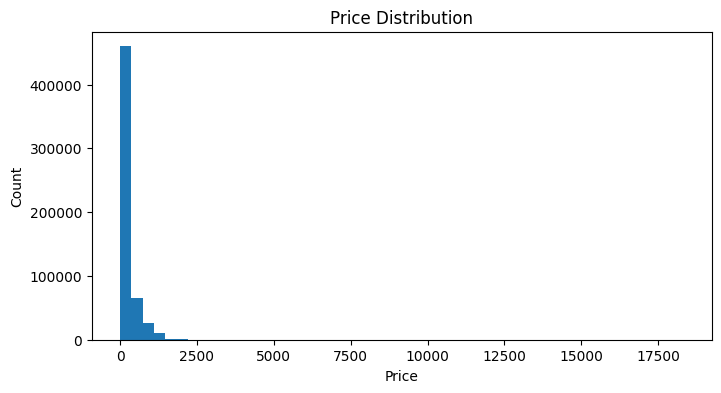

In [10]:
#basic plotting

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(df['price'], bins=50)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


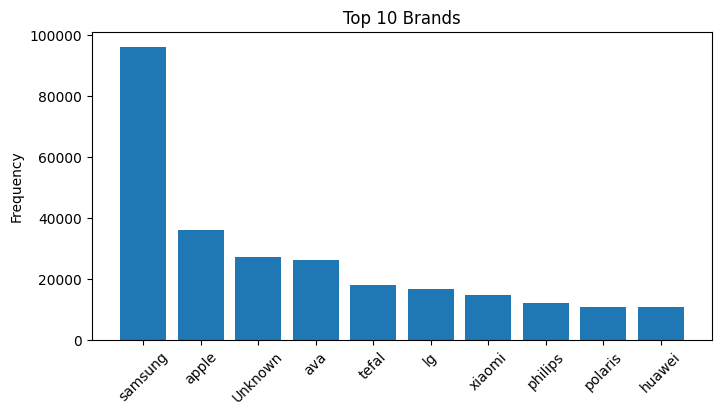

In [11]:
#checking top brands barplot

top_brands = df['brand'].value_counts().head(10)

plt.figure(figsize=(8,4))
plt.bar(top_brands.index, top_brands.values)
plt.xticks(rotation=45)
plt.title("Top 10 Brands")
plt.ylabel("Frequency")
plt.show()


In [12]:
#creating a target cariable

df['price_category'] = pd.qcut(df['price'],q=3,labels=[0,1,2])


In [13]:
#label encoding

from sklearn.preprocessing import LabelEncoder

le_cat = LabelEncoder()
le_brand = LabelEncoder()

df['category_code_enc'] = le_cat.fit_transform(df['category_code'])
df['brand_enc'] = le_brand.fit_transform(df['brand'])


In [14]:
#doing featur selection

X = df[['price' , 'category_code_enc' , 'brand_enc' , 'user_id']]
y = df['price_category']

In [15]:
#train and test split

from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.25 , random_state=42 , stratify=y)


In [16]:
#feature scaling the values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[['price']] = scaler.fit_transform(X_train[['price']])
X_test[['price']] = scaler.transform(X_test[['price']])


In [17]:
#applying random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("RandomForest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


RandomForest Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     47658
           1       1.00      1.00      1.00     46370
           2       1.00      1.00      1.00     47005

    accuracy                           1.00    141033
   macro avg       1.00      1.00      1.00    141033
weighted avg       1.00      1.00      1.00    141033



In [18]:
#preparingand optimizing xgboost

from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=300,learning_rate=0.1,max_depth=6,subsample=0.8,colsample_bytree=0.8,objective='multi:softmax',num_class=3,random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.999794374366283
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     47658
           1       1.00      1.00      1.00     46370
           2       1.00      1.00      1.00     47005

    accuracy                           1.00    141033
   macro avg       1.00      1.00      1.00    141033
weighted avg       1.00      1.00      1.00    141033



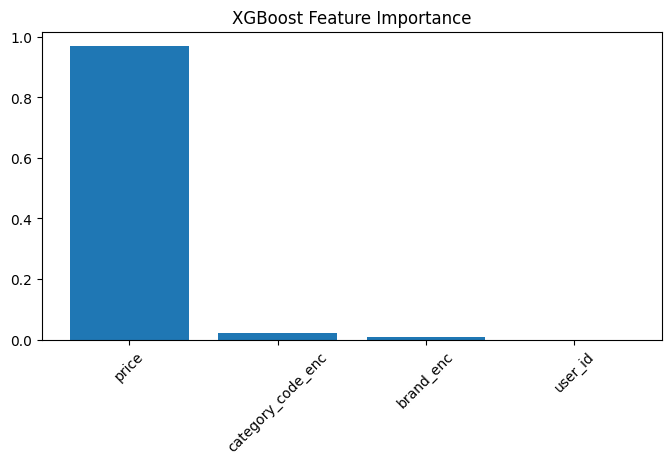

In [19]:
#plotting the feature importance of the XGboost

plt.figure(figsize=(8,4))
plt.bar(X.columns, xgb.feature_importances_)
plt.title("XGBoost Feature Importance")
plt.xticks(rotation=45)
plt.show()


In [20]:
#implementing the kmeans cluster

from sklearn.cluster import KMeans

cluster_data = df[['price', 'category_code_enc', 'brand_enc']]
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(cluster_data)
df[['price','category_code_enc','brand_enc','cluster']].head()


,price,category_code_enc,brand_enc,cluster
0,162.01,90,678,0
1,162.01,90,678,0
2,77.52,82,358,2
3,77.52,82,358,2
4,217.57,0,413,0


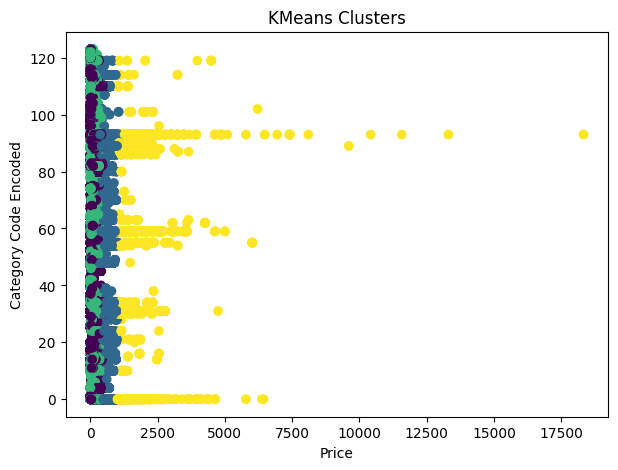

In [21]:
#trying to plot the acquired kmeans data

plt.figure(figsize=(7,5))
plt.scatter(df['price'], df['category_code_enc'], c=df['cluster'])
plt.title("KMeans Clusters")
plt.xlabel("Price")
plt.ylabel("Category Code Encoded")
plt.show()


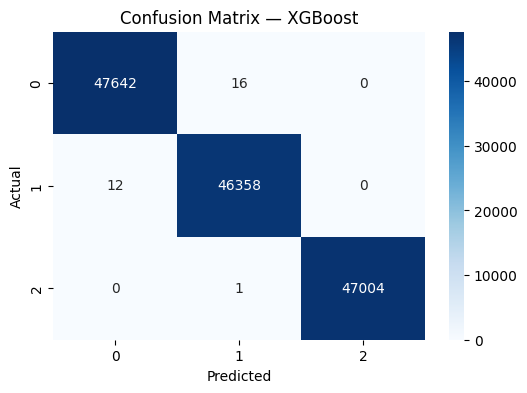

In [22]:
#securing the confusion matrix to enable more accurate and sensitive data

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [25]:
import joblib

joblib.dump(xgb, "xgboost_price_category_model.pkl")
print("Model saved successfully!")


Model saved successfully!
